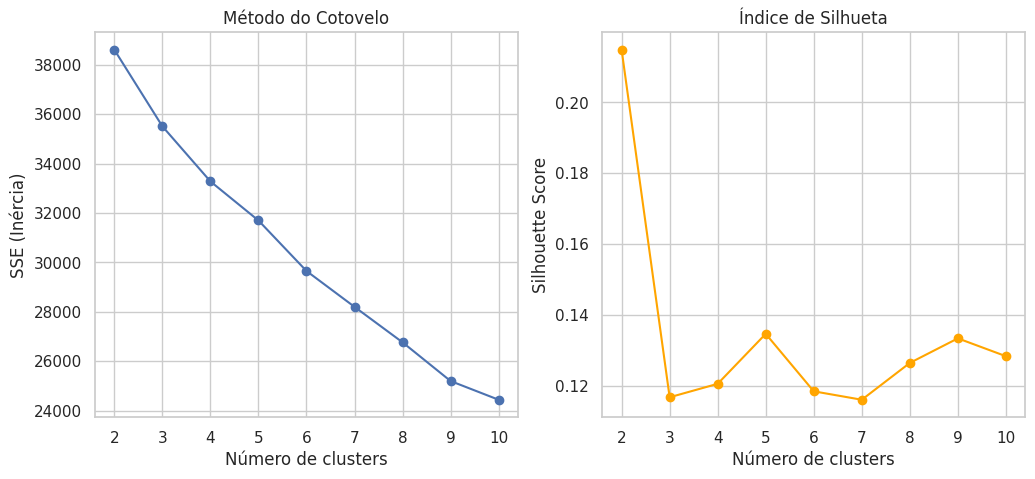

2
Melhor SVM: {'C': 0.01, 'kernel': 'poly'}
Melhor RF: {'max_depth': 10, 'n_estimators': 200}
SVM + Cluster Feature - Precision: 0.531, Recall: 0.955, F1: 0.682, ROC AUC: 0.645
Random Forest + Cluster Feature - Precision: 0.622, Recall: 0.669, F1: 0.645, ROC AUC: 0.688


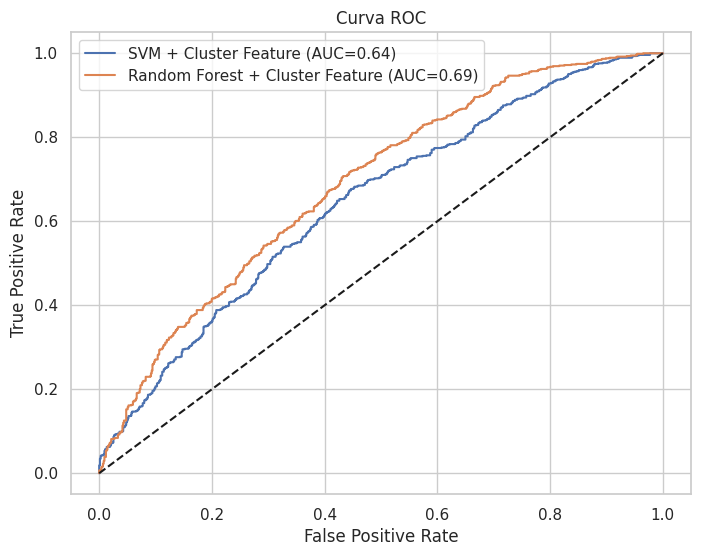

SVM Original - Precision: 0.546, Recall: 0.917, F1: 0.684, ROC AUC: 0.647
SVM + Cluster Feature - Precision: 0.531, Recall: 0.955, F1: 0.682, ROC AUC: 0.645
Random Forest + Cluster Feature - Precision: 0.622, Recall: 0.669, F1: 0.645, ROC AUC: 0.688


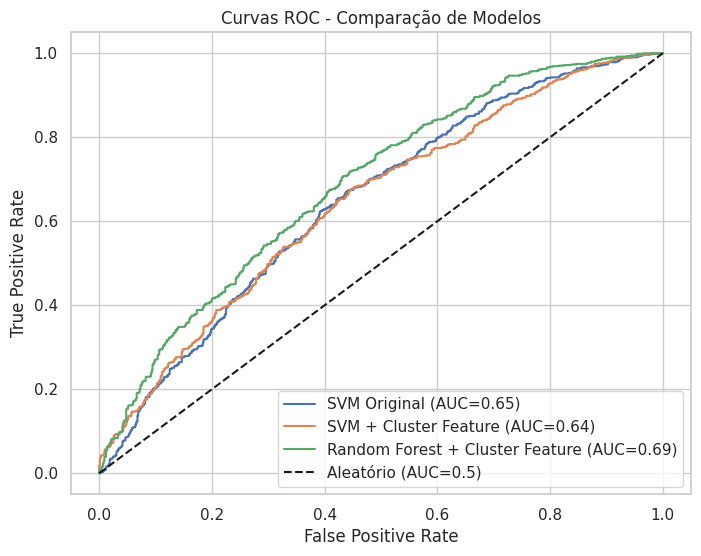

Número ótimo de clusters: 2


In [ ]:
# =========================
# 0. Carregar Dataset e Pré-processamento
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configurações gerais
np.random.seed(42)  # garante reprodutibilidade dos resultados

# Carregar dataset
df = pd.read_csv("dataset.csv")
df = df.sample(n=5000, random_state=42)  # amostra

# Selecionar apenas atributos numéricos relevantes
numerical_features = [
    'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
X = df[numerical_features]

# Escalar os dados para média 0 e desvio padrão 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criar target binário: 1 se popularidade acima da mediana, 0 caso contrário
target = (df['popularity'] > df['popularity'].median()).astype(int)

# Divisão treino/teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, target, test_size=0.3, random_state=42)

# =========================
# 1. Clusterização K-Médias
# =========================
# Avaliar diferentes números de clusters
sse = []  # soma dos erros ao quadrado (inércia)
silhouette_scores = []  # coeficiente de silhueta
K_range = range(2, 11)  # testar de 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)  # inércia do modelo
    silhouette_scores.append(silhouette_score(X_train, kmeans.labels_))  # qualidade dos clusters

# Plotar Método do Cotovelo e Índice de Silhueta
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("SSE (Inércia)")
plt.title("Método do Cotovelo")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.title("Índice de Silhueta")
plt.show()

# Escolher número ótimo de clusters baseado no maior Silhouette Score
optimal_k = K_range[np.argmax(silhouette_scores)]
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_opt.fit(X_train)  # treinar modelo final de KMeans

print(optimal_k)

# =========================
# 2. Criação de Features de Distância ao Cluster
# =========================
# Função que adiciona feature: distância mínima de cada ponto ao centroide mais próximo
def add_cluster_distance_features(X, kmeans_model):
    distances = kmeans_model.transform(X)  # distância de cada ponto para todos os centróides
    min_distances = np.min(distances, axis=1).reshape(-1,1)  # distância mínima
    return np.hstack([X, min_distances])  # concatena à matriz original

# Criar datasets expandidos com feature de cluster
X_train_exp = add_cluster_distance_features(X_train, kmeans_opt)
X_test_exp = add_cluster_distance_features(X_test, kmeans_opt)

# =========================
# 3. Treinamento de Modelos
# =========================
# 3a. SVM com GridSearch para otimizar hiperparâmetros
svm_params = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.01, 0.1, 1, 10]}
svm_clf = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1')
svm_clf.fit(X_train_exp, y_train)
print("Melhor SVM:", svm_clf.best_params_)

# 3b. Random Forest ccom GridSearch
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')
rf_clf.fit(X_train_exp, y_train)
print("Melhor RF:", rf_clf.best_params_)

#todo
# =========================
# 4. Avaliação de Modelos
# =========================
# Função para avaliar métricas de classificação e plotar ROC
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Obter probabilidades ou decision function
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalizar para [0,1]

    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    print(f"{model_name} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, ROC AUC: {roc_auc:.3f}")
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.2f})')

# Plot das curvas ROC
plt.figure(figsize=(8,6))
evaluate_model(svm_clf.best_estimator_, X_test_exp, y_test, "SVM + Cluster Feature")
evaluate_model(rf_clf.best_estimator_, X_test_exp, y_test, "Random Forest + Cluster Feature")
plt.plot([0,1], [0,1], 'k--')  # linha de ref
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

# =========================
# 5. Análise Comparativa
# =========================
# Treinar SVM original (sem feature de cluster) para comparação
svm_orig = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1')
svm_orig.fit(X_train, y_train)

plt.figure(figsize=(8,6))

evaluate_model(svm_orig.best_estimator_, X_test, y_test, "SVM Original")
evaluate_model(svm_clf.best_estimator_, X_test_exp, y_test, "SVM + Cluster Feature")
evaluate_model(rf_clf.best_estimator_, X_test_exp, y_test, "Random Forest + Cluster Feature")

plt.plot([0,1], [0,1], 'k--', label='Aleatório (AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC - Comparação de Modelos")
plt.grid(True)
plt.legend()
plt.show()

# Exibir número ótimo de clusters utilizado
print(f"Número ótimo de clusters: {optimal_k}")


'''
SVM: Adicionar a feature de cluster aumentou o recall (o modelo detecta mais
positivos), mas reduziu levemente a precisão. O F1 e ROC AUC ficaram
praticamente iguais, mostrando que o impacto geral no desempenho da SVM foi
mínimo.

Random Forest: apresenta desempenho equilibrado entre precisão e recall, com
AUC maior que a SVM. Aqui, a feature de cluster parece ter ajudado a capturar
padrões que a SVM não captou

Número ótimo de clusters: 2

Poucos clusters podem indicar que os dados não possuem muita complexidade
latente para clusterização, o que explica o impacto moderado da feature nos
modelos.
'''
